#### evaluate CNR in the CBF images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import scipy.ndimage

In [2]:
import sys
sys.path.append('../../Preprocess/')
import BiasCorrection as BC
import CalcParaMaps

In [3]:
# load ROIs
lesionROIs = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/evals/rois/lesion.npy', allow_pickle=True)
stdROIs = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/evals/rois/std.npy', allow_pickle=True)

In [4]:
# load original images for bias correction
imgDir = '/home/dwu/trainData/Noise2Noise/train/ctp/real/data/'
imgNorm = 0.15
nTest = 5
imgs = np.load(os.path.join(imgDir, 'imgs4d.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
masks = np.load(os.path.join(imgDir, 'mask.npy'), allow_pickle=True)[-nTest:]
aifs = np.load(os.path.join(imgDir, 'aif.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
vofs = np.load(os.path.join(imgDir, 'vof.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
cbfFacs = np.load(os.path.join(imgDir, 'cbfFac.npy'), allow_pickle=True)[-nTest:]

In [5]:
for i in range(len(imgs)):
    maskVessel = np.where(np.max(imgs[i], -1) > 0.1 / imgNorm, 1, 0)[...,np.newaxis]
    maskVessel *= masks[i]
    for k in range(maskVessel.shape[0]):
        maskVessel[k,...,0] = scipy.ndimage.morphology.binary_dilation(maskVessel[k,...,0])
    masks[i] *= (1 - maskVessel)

for i in range(len(imgs)):
    imgs[i] *= masks[i]
    
tacs = []
for i in range(len(imgs)):
    tacs.append(imgs[i] - (imgs[i][...,[0]] + imgs[i][...,[1]]) / 2)

In [6]:
for i in range(len(masks)):
    lesionROIs[i] *= masks[i]
    stdROIs[i] *= masks[i]

In [7]:
def GetROIContrastAndNoise(imgs, lesionROIs, stdROIs):
    contrasts = []
    stds = []
    for i in range(len(imgs)):
        if lesionROIs[i].sum() > 0:
            lesion = np.sum(imgs[i] * lesionROIs[i]) / np.sum(lesionROIs[i])
            ref = np.sum(imgs[i] * stdROIs[i]) / np.sum(stdROIs[i])
            std = np.sqrt(np.sum((imgs[i] - ref)**2 * stdROIs[i]) / np.sum(stdROIs[i]))
            
            contrasts.append(ref - lesion)
            stds.append(std)

    return np.array(contrasts), np.array(stds)

In [8]:
# CNR of gaussian
gaussContrasts = []
gaussStds = []
gaussCNRs = []
guassSigmas = []
filenames = glob.glob('/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_*.npy')
for filename in filenames:
    print (filename)
    tokens = os.path.basename(filename).strip('.npy').split('_')
    
    guassSigmas.append(float(tokens[-1]))
    res = np.load(filename, allow_pickle=True)
    cbfs = []
    for i in range(len(res)):
        cbf, _, _ = CalcParaMaps.CalcParaMaps(res[i] * masks[i], masks[i], vof = np.copy(vofs[i]), aif = np.copy(aifs[i]))
        cbfs.append((cbf * cbfFacs[i])[...,np.newaxis])
    
    c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
    
    gaussContrasts.append(np.mean(c))
    gaussStds.append(np.mean(s))
    gaussCNRs.append(np.mean(c / s))

inds = np.argsort(guassSigmas)
guassSigmas = np.array(guassSigmas)[inds]
gaussContrasts = np.array(gaussContrasts)[inds]
gaussStds = np.array(gaussStds)[inds]
gaussCNRs = np.array(gaussCNRs)[inds]

/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_1.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_2.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_3.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_4.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_0.npy


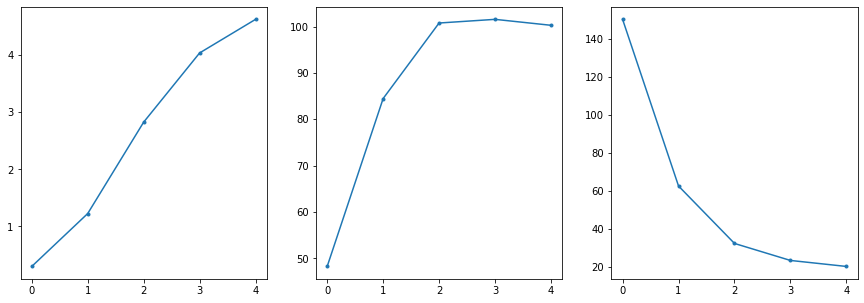

In [9]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.plot(guassSigmas, gaussCNRs, '.-')
plt.subplot(132); plt.plot(guassSigmas, gaussContrasts, '.-')
plt.subplot(133); plt.plot(guassSigmas, gaussStds, '.-')

In [10]:
# cnr of TIPS
tipsContrasts = {}
tipsStds = {}
tipsCNRs = {}
tipsSigmas = {}
filenames = glob.glob('/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS*.npy')
for filename in filenames:
    print (filename)
    tokens = os.path.basename(filename).strip('.npy').split('_')
    
    sigma1 = float(tokens[2])
    sigma2 = float(tokens[3])
    
    res = np.load(filename, allow_pickle=True)
    cbfs = []
    for i in range(len(res)):
        cbf, _, _ = CalcParaMaps.CalcParaMaps(res[i] * masks[i], masks[i], vof = np.copy(vofs[i]), aif = np.copy(aifs[i]))
        cbfs.append((cbf * cbfFacs[i])[...,np.newaxis])
        
    c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
    
    if sigma1 not in tipsSigmas:
        tipsContrasts[sigma1] = []
        tipsStds[sigma1] = []
        tipsCNRs[sigma1] = []
        tipsSigmas[sigma1] = []
        
    tipsContrasts[sigma1].append(np.mean(c))
    tipsStds[sigma1].append(np.mean(s))
    tipsCNRs[sigma1].append(np.mean(c / s))
    tipsSigmas[sigma1].append(sigma2)

for sigma in tipsSigmas:
    inds = np.argsort(tipsSigmas[sigma])
    tipsSigmas[sigma] = np.array(tipsSigmas[sigma])[inds]
    tipsContrasts[sigma] = np.array(tipsContrasts[sigma])[inds]
    tipsStds[sigma] = np.array(tipsStds[sigma])[inds]
    tipsCNRs[sigma] = np.array(tipsCNRs[sigma])[inds]

/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.075_1.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.05_1.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.025_1.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.1_1.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.025_2.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.1_2.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.05_2.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.075_2.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.05_3.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.075_3.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.025_3.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.1_3.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.1_4.npy
/home/dwu/trainData/Noise2Noise/trai

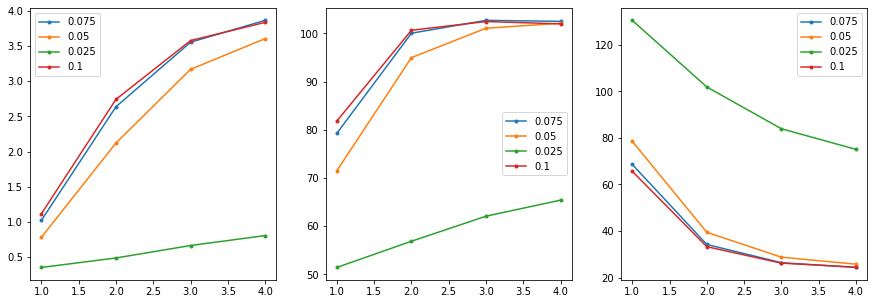

In [11]:
plt.figure(figsize=[15,5])
plt.subplot(131)
for sigma in tipsSigmas:
    plt.plot(tipsSigmas[sigma], tipsCNRs[sigma], '.-')
plt.legend([k for k in tipsSigmas])

plt.subplot(132)
for sigma in tipsSigmas:
    plt.plot(tipsSigmas[sigma], tipsContrasts[sigma], '.-')
plt.legend([k for k in tipsSigmas])

plt.subplot(133)
for sigma in tipsSigmas:
    plt.plot(tipsSigmas[sigma], tipsStds[sigma], '.-')
plt.legend([k for k in tipsSigmas])

In [19]:
# cnr of TV, this is a little different since TV directly saved the CBF
tvContrasts = {}
tvStds = {}
tvCNRs = {}
tvBetas = {}
filenames = glob.glob('/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV*.npz')
for filename in filenames:
    print (filename)
    tokens = os.path.basename(filename).strip('.npz').split('_')
    
    beta1 = float(tokens[2])
    beta2 = float(tokens[3])

    cbfs = np.load(filename, allow_pickle=True)['cbf']
    for i in range(len(cbfs)):
        cbfs[i] = cbfs[i][...,np.newaxis] * masks[i]
        
    c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
    
    if beta1 not in tvBetas:
        tvContrasts[beta1] = []
        tvStds[beta1] = []
        tvCNRs[beta1] = []
        tvBetas[beta1] = []
        
    tvContrasts[beta1].append(np.mean(c))
    tvStds[beta1].append(np.mean(s))
    tvCNRs[beta1].append(np.mean(c / s))
    tvBetas[beta1].append(beta2)

for beta in tvBetas:
    inds = np.argsort(tvBetas[beta])
    tvBetas[beta] = np.array(tvBetas[beta])[inds]
    tvContrasts[beta] = np.array(tvContrasts[beta])[inds]
    tvStds[beta] = np.array(tvStds[beta])[inds]
    tvCNRs[beta] = np.array(tvCNRs[beta])[inds]

/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_7.5e-4_7.5e-5.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_7.5e-4_5e-5.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_7.5e-4_2.5e-4.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_7.5e-4_1e-4.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_1e-3_2.5e-4.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_1e-3_1e-4.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_1e-3_7.5e-5.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_1e-3_5e-5.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_2.5e-3_2.5e-4.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_2.5e-3_7.5e-5.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_2.5e-3_1e-4.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_2.5e-3_5e-5.npz
/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_5e-3_5e-5.npz
/home/dwu/trainData/Noise2Noise/trai

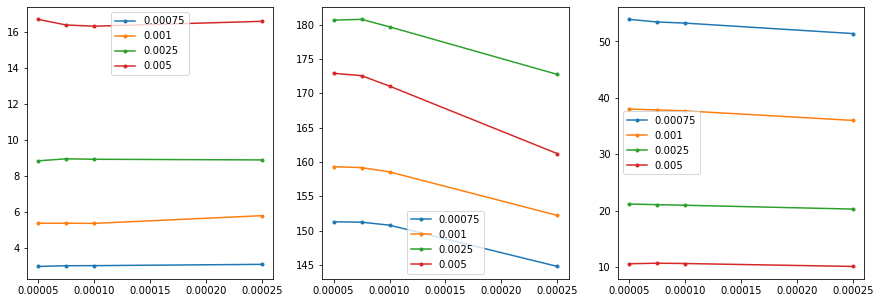

In [20]:
plt.figure(figsize=[15,5])
plt.subplot(131)
for beta in tvBetas:
    plt.plot(tvBetas[beta], tvCNRs[beta], '.-')
plt.legend([k for k in tvBetas])

plt.subplot(132)
for beta in tvBetas:
    plt.plot(tvBetas[beta], tvContrasts[beta], '.-')
plt.legend([k for k in tvBetas])

plt.subplot(133)
for beta in tvBetas:
    plt.plot(tvBetas[beta], tvStds[beta], '.-')
plt.legend([k for k in tvBetas])

In [14]:
# cnr of Noise2Noise
n2nContrasts = []
n2nStds = []
n2nCNRs = []
n2nBetas = []
dirnames = glob.glob('/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_*')
for dirname in dirnames:
    print (dirname)
    tokens = os.path.basename(dirname).split('_')
    n2nBetas.append(float(tokens[-1]))
    
    res = np.load(os.path.join(dirname, 'tmp', 'iodines.npy'), allow_pickle=True)[-nTest:]
    cbfs = []
    for i in range(len(res)):
        res[i] = res[i] * 0.025 / imgNorm
        # bias correction
        res[i] = BC.BiasCorrection(res[i], tacs[i], masks[i])
        # deconvolution
        cbf, _, _ = CalcParaMaps.CalcParaMaps(res[i] * masks[i], masks[i], vof = np.copy(vofs[i]), aif = np.copy(aifs[i]))
        cbfs.append((cbf * cbfFacs[i])[...,np.newaxis])
    
    c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
    
    n2nContrasts.append(np.mean(c))
    n2nStds.append(np.mean(s))
    n2nCNRs.append(np.mean(c / s))

inds = np.argsort(n2nBetas)
n2nBetas = np.array(n2nBetas)[inds]
n2nContrasts = np.array(n2nContrasts)[inds]
n2nStds = np.array(n2nStds)[inds]
n2nCNRs = np.array(n2nCNRs)[inds]

/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_0
/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_50
/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_25
/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_12.5
/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_37.5


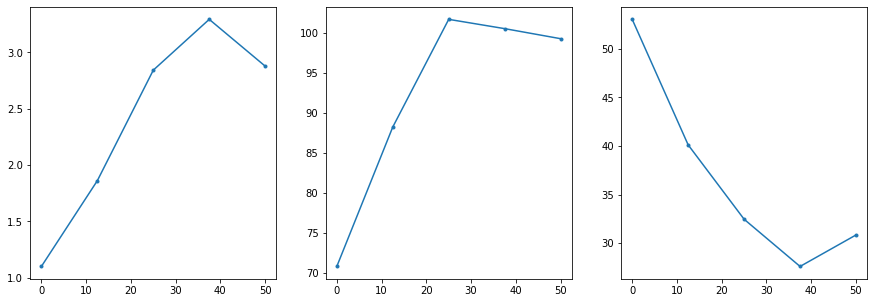

In [15]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.plot(n2nBetas, n2nCNRs, '.-')
plt.subplot(132); plt.plot(n2nBetas, n2nContrasts, '.-')
plt.subplot(133); plt.plot(n2nBetas, n2nStds, '.-')

In [16]:
# bias and std of supervised learning
supContrasts = []
supStds = []
supCNRs = []
supBetas = []
filenames = glob.glob('/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised*.npy')
for filename in filenames:
    print (filename)
    tokens = os.path.basename(filename).strip('.npy').split('_')
    if len(tokens) < 3:
        continue
    supBetas.append(float(tokens[-1]))
    
    res = np.load(filename, allow_pickle=True)
    cbfs = []
    for i in range(len(res)):
        res[i] = res[i] * 0.025 / imgNorm
        # bias correction
        res[i] = BC.BiasCorrection(res[i], tacs[i], masks[i])
        # deconvolution
        cbf, _, _ = CalcParaMaps.CalcParaMaps(res[i] * masks[i], masks[i], vof = np.copy(vofs[i]), aif = np.copy(aifs[i]))
        cbfs.append((cbf * cbfFacs[i])[...,np.newaxis])
    
    c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
    
    supContrasts.append(np.mean(c))
    supStds.append(np.mean(s))
    supCNRs.append(np.mean(c/s))

inds = np.argsort(supBetas)
supBetas = np.array(supBetas)[inds]
supContrasts = np.array(supContrasts)[inds]
supStds = np.array(supStds)[inds]
supCNRs = np.array(supCNRs)[inds]

/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_0.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_12.5.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_25.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_37.5.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_50.npy


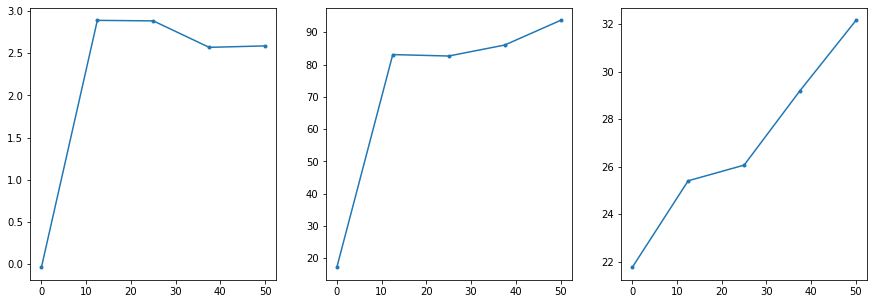

In [17]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.plot(supBetas, supCNRs, '.-')
plt.subplot(132); plt.plot(supBetas, supContrasts, '.-')
plt.subplot(133); plt.plot(supBetas, supStds, '.-')

In [18]:
plt.plot(n2nBiases, n2nStds, 'o')
plt.plot(supBiases, supStds, 'o')
# plt.plot(gaussianBiases, gaussianStds, 'o')

NameError: name 'n2nBiases' is not defined

In [ ]:
gau = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_2.npy', allow_pickle=True)
tips = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.1_2.npy', allow_pickle=True)
n2n = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_25/tmp/iodines.npy', allow_pickle=True)[-nTest:] * 0.025 / imgNorm
n2c = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_37.5.npy', allow_pickle=True)[-nTest:] * 0.025 / imgNorm

In [ ]:
plt.figure(figsize=[20,5])
plt.subplot(141); plt.imshow(gau[2][7, ..., 20], 'gray', vmin=0, vmax=0.2)
plt.subplot(142); plt.imshow(tips[2][7, ..., 20], 'gray', vmin=0, vmax=0.2)
plt.subplot(143); plt.imshow(n2n[2][7, ..., 20], 'gray', vmin=0, vmax=0.2)
plt.subplot(144); plt.imshow(n2c[2][7, ..., 20], 'gray', vmin=0, vmax=0.2)

In [ ]:
aifs = np.load(os.path.join(imgDir, 'aif.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
vofs = np.load(os.path.join(imgDir, 'vof.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
cbfFacs = np.load(os.path.join(imgDir, 'cbfFac.npy'), allow_pickle=True)[-nTest:]

In [ ]:
bc2 = BC.BiasCorrection(n2n[2], tacs[2], masks[2])
cbfN2n, cbvN2n, mttN2n = CalcParaMaps.CalcParaMaps(bc2, masks[2], vof = vofs[2], aif = aifs[2])
cbfN2n *= cbfFacs[2]
mttN2n /= cbfFacs[2]

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbfN2n[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=300)
plt.subplot(132); plt.imshow(cbvN2n[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=5)
plt.subplot(133); plt.imshow(mttN2n[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=2)

In [ ]:
cbfTips, cbvTips, mttTips = CalcParaMaps.CalcParaMaps(tips[2], masks[2], vof = vofs[2], aif = aifs[2])
cbfTips *= cbfFacs[2]
mttTips /= cbfFacs[2]

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbfTips[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=300)
plt.subplot(132); plt.imshow(cbvTips[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=5)
plt.subplot(133); plt.imshow(mttTips[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=2)

In [ ]:
cbfGauss, cbvGauss, mttGauss = CalcParaMaps.CalcParaMaps(gau[2], masks[2], vof = vofs[2], aif = aifs[2])
cbfGauss *= cbfFacs[2]
mttGauss /= cbfFacs[2]

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbfGauss[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=300)
plt.subplot(132); plt.imshow(cbvGauss[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=5)
plt.subplot(133); plt.imshow(mttGauss[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=2)

In [ ]:
bc2 = BC.BiasCorrection(n2c[2], tacs[2], masks[2])
cbfN2c, cbvN2c, mttN2c = CalcParaMaps.CalcParaMaps(bc2, masks[2], vof = vofs[2], aif = aifs[2])
cbfN2c *= cbfFacs[2]
mttN2c /= cbfFacs[2]

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbfN2c[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=300)
plt.subplot(132); plt.imshow(cbvN2c[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=5)
plt.subplot(133); plt.imshow(mttN2c[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=2)

In [ ]:
with np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_1e-3_2.5e-4.npz', allow_pickle=True) as f:
    cbfTV = f['cbf']
    cbvTV = f['cbv']
    mttTV = f['mtt']

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbfTV[2][7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=300)
plt.subplot(132); plt.imshow(cbvTV[2][7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=5)
plt.subplot(133); plt.imshow(mttTV[2][7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=2)